In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#import h5py
import sys
import os
import pyflct
from scipy.stats import pearsonr
from tqdm import tqdm
import time
# We need this to navigate through our data
import muram as muram

# Input/output
from astropy.io import fits

In [4]:
# fromfile loading
first = np.fromfile("tau_slice_0.100.000000", dtype = "float32")
first_ = first[4:].reshape(11, 1536, 1536)
Bz_1 = first_[7,:,:]
Bz_1 = Bz_1 * np.sqrt(4*np.pi)

In [5]:
# read_slice loading
path = ''
data1 = muram.read_slice(path, 0, 'tau', '0.100' )
test1 = np.copy(data1[0][5,:,:] * np.sqrt(4 * np.pi))

Text(0.5, 1.0, 'read_slice reading')

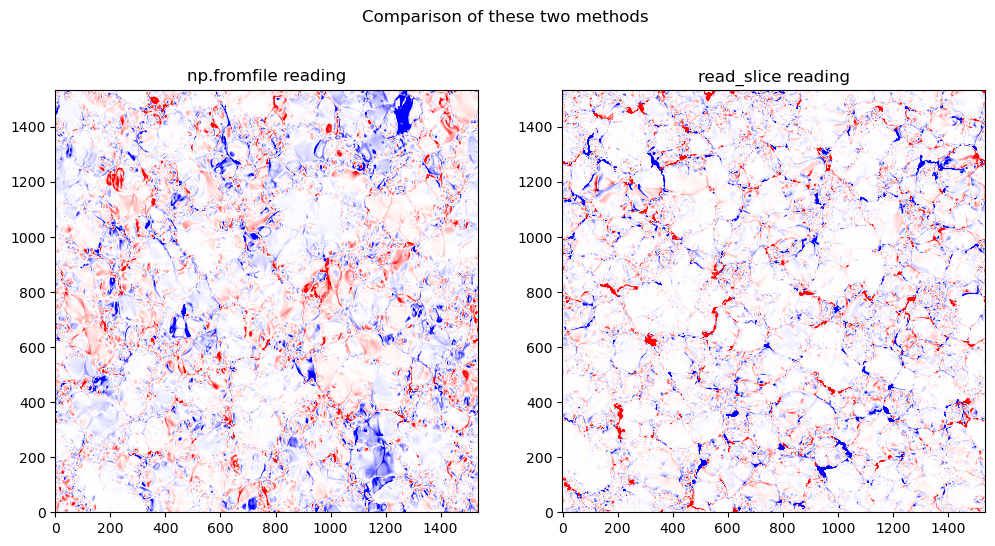

In [8]:
# Comparison of these two methods
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison of these two methods")
ax1 = fig.add_subplot(121)
ax1.imshow(Bz_1[:,:], origin='lower',cmap='bwr', vmin = -200, vmax = 200)
ax1.set_title("np.fromfile reading") 

ax2 = fig.add_subplot(122)
ax2.imshow(test1[:,:], origin='lower', cmap='bwr', vmin = -200, vmax = 200)
ax2.set_title("read_slice reading") 

In [2]:
filenames = []

# Retreiving only numerical files
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("tau_slice_0.100"):
		#print (file)
		filenames.append(file)

In [3]:
bz = []
vxr = []
vyr = []

In [4]:
test_range = 4
for iter in range(test_range):
    test = filenames[iter]
    print(test)
    data_full = np.fromfile(test, dtype="float32")
    data = data_full[4:].reshape(11, 1536, 1536)
    Bz = data[7,:,:]
    Vx = data[1,:,:]
    Vy = data[2,:,:]
    vxr.append(Vx)
    vyr.append(Vy)
    bz.append(Bz)

tau_slice_0.100.000000
tau_slice_0.100.000050
tau_slice_0.100.000100
tau_slice_0.100.000150


In [5]:
print(bz)

[array([[-1.2307711e-01, -6.1460692e-02,  9.7903007e-01, ...,
         1.5572692e+01, -5.9001675e+00, -2.4108095e+00],
       [ 1.4817357e+00,  1.1856296e+00,  1.4907622e+00, ...,
         4.3594765e+01,  8.7437028e-01, -1.9654992e+00],
       [ 4.1264677e+00,  4.5370173e+00,  2.8614097e+00, ...,
         6.4753395e+01,  1.8671873e+01, -5.7184333e-01],
       ...,
       [-1.7290819e+00,  1.0581242e+00,  4.7954869e+00, ...,
        -1.0203753e+01, -5.8869681e+00, -3.5273857e+00],
       [-2.2132192e+00, -8.5384148e-01,  2.3429048e+00, ...,
        -8.9488935e+00, -6.1397605e+00, -3.0906522e+00],
       [-2.4152336e+00, -1.1099466e+00,  8.1951374e-01, ...,
        -7.4231040e-01, -6.0170689e+00, -2.8802278e+00]], dtype=float32), array([[-0.90205973, -0.33192447,  0.28235278, ..., 50.022545  ,
         2.6317778 , -4.5267444 ],
       [ 0.31254798,  1.52517   ,  1.869989  , ..., 75.27784   ,
        23.950302  , -2.1018913 ],
       [ 2.548713  ,  5.4114146 ,  4.4455156 , ..., 80.0945   

In [20]:
bz = np.asarray(bz)
bz = bz*np.sqrt(4*np.pi)
vxr = np.asarray(vxr)
vyr = np.asarray(vyr)

In [26]:
bz = []

first = np.fromfile("tau_slice_0.100.000000", dtype = "float32")
first_ = first[4:].reshape(11, 1536, 1536)
Bz_1 = first_[7,:,:]
bz.append(Bz_1)

second = np.fromfile("tau_slice_0.100.000150", dtype = "float32")
second_ = second[4:].reshape(11, 1536, 1536)
Bz_2 = second_[7,:,:]
bz.append(Bz_2)

In [27]:
print("Bz shape:", np.shape(bz))
# Now we can define cadence, FWHM, pixelsize and sigma that FLCT will use 

deltat = 30 # in seconds
fwhm = 100 # in kilometres
pixelsize = 16 # in kilometres
sigma = fwhm/1.665/pixelsize # size of the apodizing window
threshold = 0

Bz shape: (2, 1536, 1536)


In [28]:
vxb, vyb, vmb = pyflct.flct(bz[0], bz[1], deltat, pixelsize, sigma, thresh = 0)
vxb = np.asarray(vxb)
vyb = np.asarray(vyb)
vmb = np.asarray(vmb)
ts = time.time()

flct: nominal sliding box size = 12
flct: mean value of gamma^2/sigma^2 = 0.326077 = 864 out of 1535

flct: finished


In [29]:
# Create the fits file to store these velocities
# with appropriate header
cube = np.concatenate((vxb[None,:,:], vyb[None,:,:]), axis = 0)
print(np.shape(cube))
out0 = fits.PrimaryHDU(cube[0])

# Header information 
out0.header['UNITS'] = 'km/s' # units that velocities are in 
out0.header['TRACKED'] = 'Bz' # the parameter which was tracked
out0.header['WHEN_RUN'] = ts # timestamp of run
out0.header['AUTHOR'] = 'Teodor'
out0.header['FWHM'] = fwhm # in kilometres
out0.header['PIXELSIZE'] = pixelsize
out0.header['SIGMA'] = sigma # FLCT window in kilometres 
out0.header['DELTAT'] = deltat # time interval between two frames in seconds
out0.header['THRESHOLD'] = threshold # FLCT is not applied to pixels below this
out0.header['SIMSTEP'] = 0.2 # should match the filename
out0.header['SIMTIME'] = 3600 # 1 hour
out0.header['COMMENT'] = ''

out1 = fits.ImageHDU(cube[1])
#out2 = fits.ImageHDU(cube[2])
out = fits.HDUList([out0, out1])



out.writeto("pyFLCT_fwhm" + str(fwhm) + "_dt" + str(deltat) + "_Bz_" + filenames[0] + "_example.fits", overwrite=True)

(2, 1536, 1536)


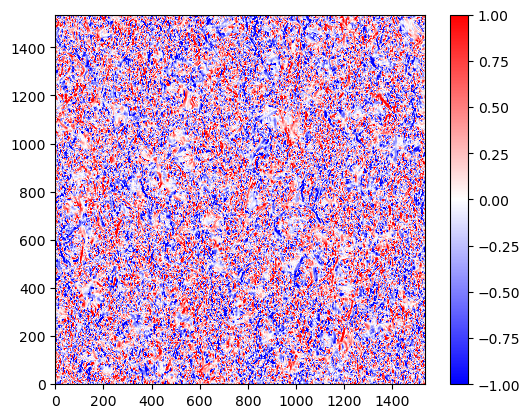

In [30]:
novo_v = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000_example.fits")[0].data
plt.imshow(novo_v, origin = "lower", cmap = "bwr", vmin = -1, vmax = 1)
plt.colorbar()

Text(0.5, 1.0, 'My code')

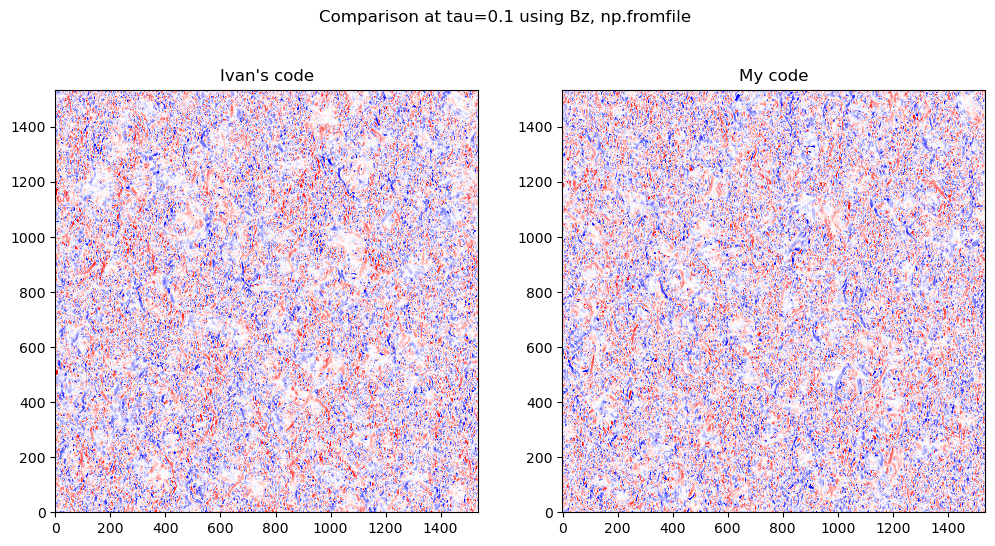

In [40]:
fcube_Ivan = fits.open("ivan_flct_Bz_30s_tau0.1_fwhm100_tracked.fits")[0].data
cube_Teodor = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000_example.fits")[0].data 
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz, np.fromfile")
ax1 = fig.add_subplot(121)
ax1.imshow(fcube_Ivan[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(cube_Teodor[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 

In [36]:
# Opening files using read_slice function
path = ''
data1 = muram.read_slice(path, 0, 'tau', '0.100' )
test1 = np.copy(data1[0][5,:,:] * np.sqrt(4 * np.pi))

data2 = muram.read_slice(path, 150, 'tau', '0.100')
test2 = np.copy(data2[0][5,:,:] * np.sqrt(4 * np.pi))

In [37]:
vel_x, vel_y, vm = pyflct.flct(test1, test2, deltat, pixelsize, sigma)

flct: nominal sliding box size = 12
flct: mean value of gamma^2/sigma^2 = 0.307698f 1535

flct: finished


Text(0.5, 1.0, 'My code')

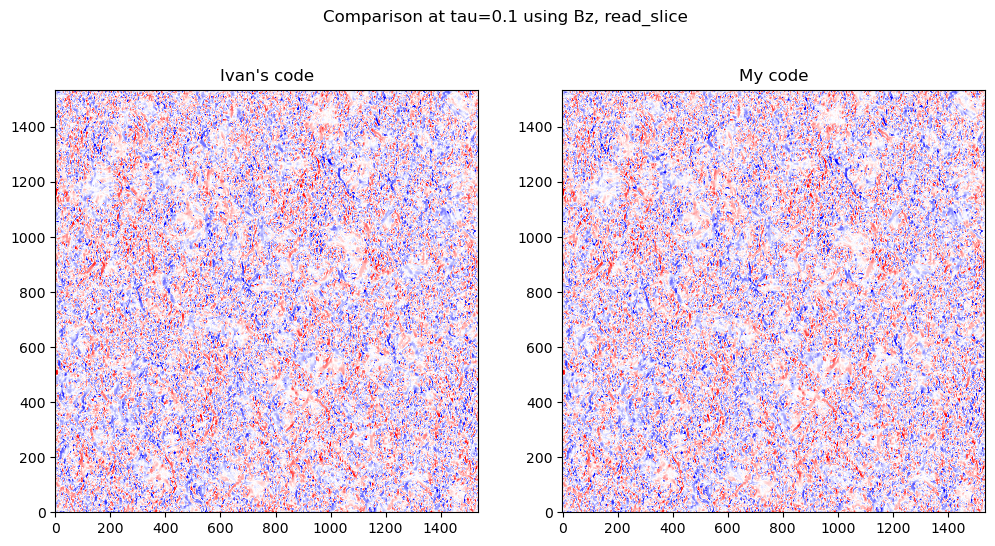

In [39]:
fcube_Ivan = fits.open("ivan_flct_Bz_30s_tau0.1_fwhm100_tracked.fits")[0].data
#cube_Teodor = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000_example.fits")[0].data 
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz, read_slice")
ax1 = fig.add_subplot(121)
ax1.imshow(fcube_Ivan[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(vel_x[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 

In [ ]:
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz, read_slice")
ax1 = fig.add_subplot(121)
ax1.imshow(Bz_1[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(test1[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 

<h1 style = "color:blue">4. 6. 2024.</h1>
<p>
    Opening the file that contains whole time series
</p>

In [2]:
Int_series_vx = fits.open("pyFLCT_fwhm_1200_dt_30_Inte_tracked.fits")[0].data # Vx
Int_series_vy = fits.open("pyFLCT_fwhm_1200_dt_30_Inte_tracked.fits")[1].data # Vy

In [3]:
np.shape(Int_series_vx)

(360, 1536, 1536)

Text(0.5, 1.0, 'Velocity between 5th and 6th')

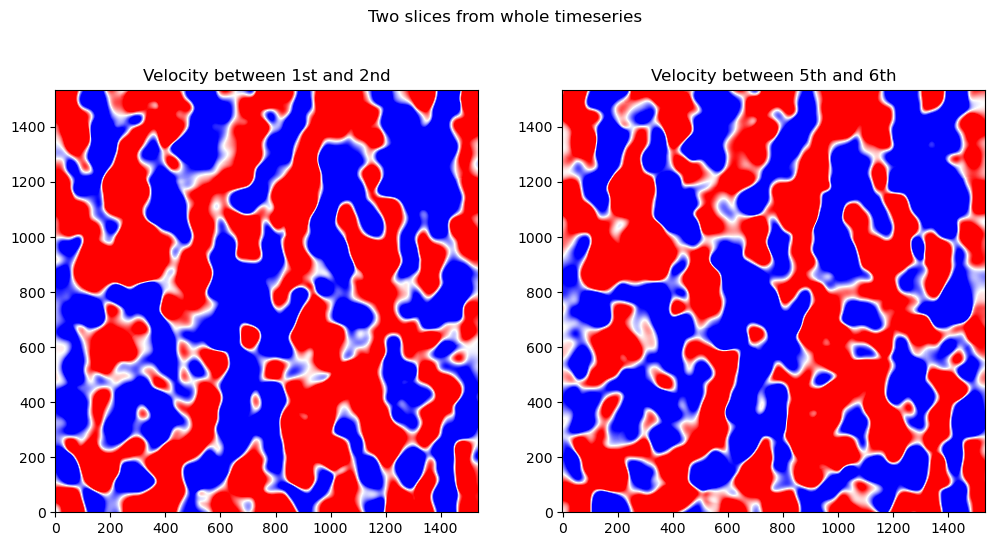

In [4]:
# Comparison of these two methods
fig = plt.figure(figsize = (12,6))
fig.suptitle("Two slices from whole timeseries")
ax1 = fig.add_subplot(121)
ax1.imshow(Int_series_vx[0,:,:], origin='lower',cmap='bwr', vmin = -0.1, vmax = 0.1)
ax1.set_title("Velocity between 1st and 2nd") 

ax2 = fig.add_subplot(122)
ax2.imshow(Int_series_vx[4,:,:], origin='lower', cmap='bwr', vmin = -0.1, vmax = 0.1)
ax2.set_title("Velocity between 5th and 6th") 

In [6]:
# Let's upload mean Vx and Vy from simulations
mean_vx = fits.open("Mean_velocities.fits")[0].data
mean_vy = fits.open("Mean_velocities.fits")[1].data

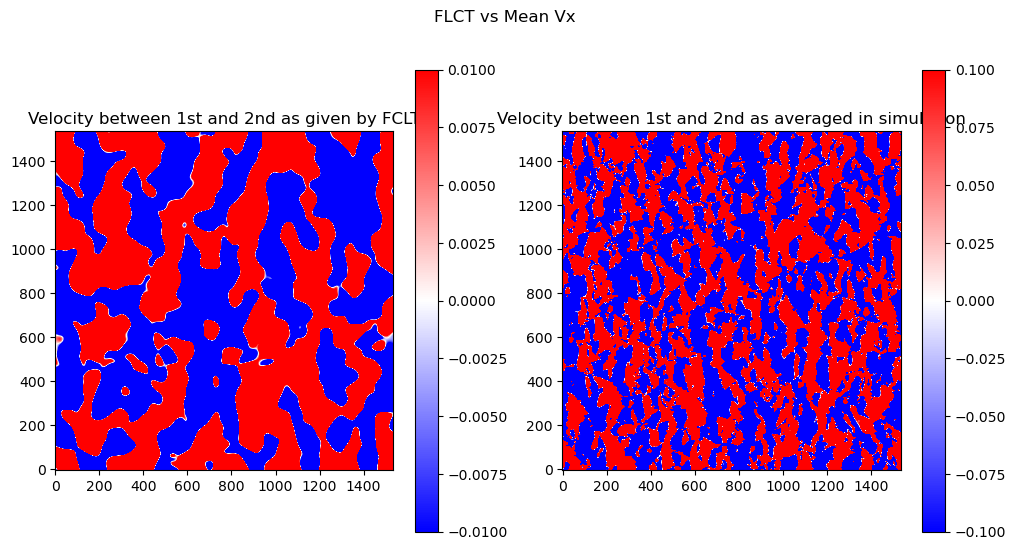

In [9]:
# Ploting mean velocties vs FLCT deriven
fig = plt.figure(figsize = (12,6))
fig.suptitle("FLCT vs Mean Vx")
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(Int_series_vx[0,:,:], origin='lower',cmap='bwr', vmin = -0.01, vmax = 0.01)
ax1.set_title("Velocity between 1st and 2nd as given by FCLT") 
fig.colorbar(im1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(mean_vx[0,:,:], origin='lower', cmap='bwr', vmin = -0.1, vmax = 0.1)
ax2.set_title("Velocity between 1st and 2nd as averaged in simulation") 
fig.colorbar(im2)

Text(0.5, 1.0, 'Flow Field based on mean velocity from simulation')

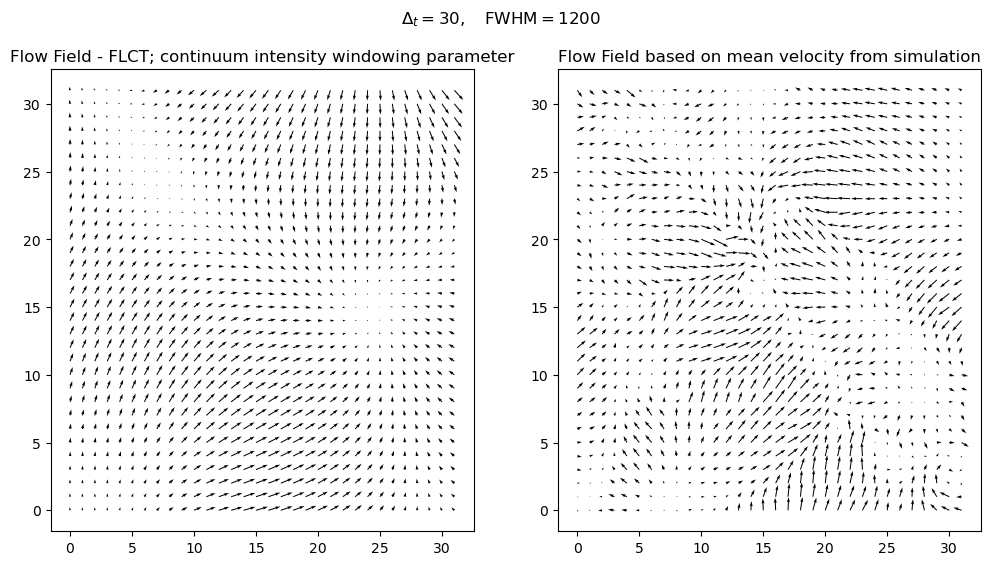

In [8]:
# Here we use quiver to represent velocities as vectors
# Plotting side by side comparison

i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)

fig = plt.figure(figsize=(12, 6))
fig.suptitle(r'$\Delta_t=30, \quad \mathrm{FWHM}=1200$')
ax1 = fig.add_subplot(121)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Int_series_vx[0,i_start:i_end:4, j_start:j_end:4], Int_series_vy[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field - FLCT; continuum intensity windowing parameter")

ax2 = fig.add_subplot(122)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          mean_vx[0,i_start:i_end:4, j_start:j_end:4], mean_vy[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field based on mean velocity from simulation") 

<p>
    There is resemblance of the original flow field, but it is yet to be determined how much of flow can be recovered.
</p>

<h1>
    6.6.2024.
</h1>
<p>
    Time averaging first 20 slices
</p>

In [33]:
# We need to take first 20 elements of Int_series_vx and average them
# After that we repeat the process on mean_vx
mean_tI = []
#Int_series_vx.reshape(360, 1536, 1536)
for j in range(1, 21):
    #mean = np.mean(Int_series_vx[j-1] + Int_series_vx[j], axis = 1)
    mean = Int_series_vx.mean(axis = 0)
    mean_tI.append(mean)
mean_tI = np.asarray(mean_tI)

# Here, we repeat the process for velocities given in simulation
# Let's open those files
Vx = fits.open("Velocities.fits")[0].data
Vy = fits.open("Velocities.fits")[1].data

Vx_mean = []
Vy_mean = []
for j in range(1, 21):
    mean = Vx.mean(axis = 0)
    Vx_mean.append(mean)

Vx_mean = np.asarray(Vx_mean)

In [49]:
# Define functions for temporal and spatial averaging
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end], axis = 0)
    return tmp_avg

In [62]:
Vx_mean_FLCT = temporal_avg(Int_series_vx, 0, 180)

In [63]:
Vx_mean_sim = temporal_avg(Vx, 0, 180) # simulation
Vx_mean_sim = Vx_mean_sim/1E5

In [69]:
Vy_mean_sim = temporal_avg(Vy, 0, 180) # simulation
Vy_mean_sim = Vy_mean_sim/1E5

In [52]:
np.shape(Vx_mean_FLCT)

(1536, 1536)

In [53]:
np.shape(Vx_mean_sim)

(1536, 1536)

In [43]:
from scipy.ndimage import gaussian_filter

In [67]:
Vx_mean_filtered = gaussian_filter(Vx_mean_sim, 25, mode = "wrap")

In [71]:
Vy_mean_filtered = gaussian_filter(Vy_mean_sim, 25, mode = "wrap")

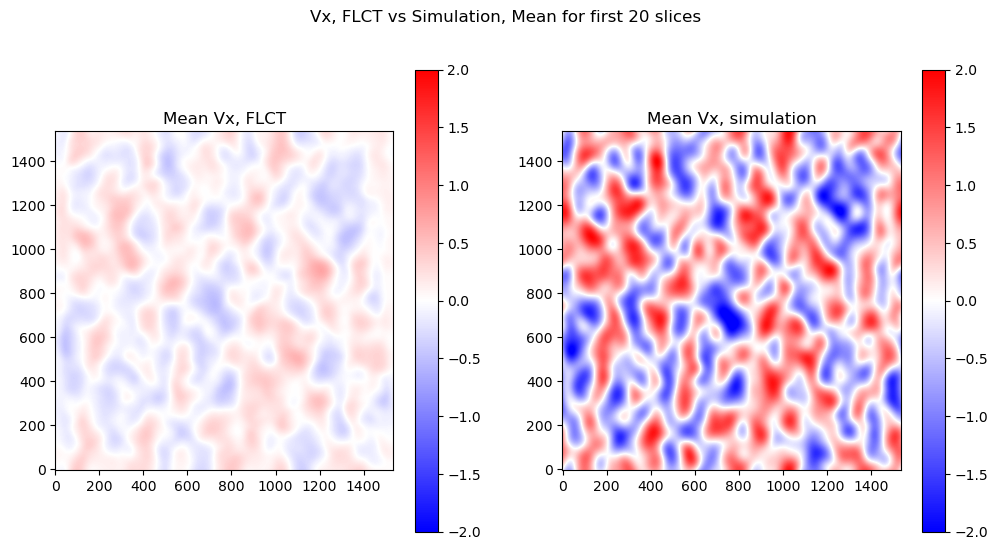

In [72]:
# Ploting mean velocties vs FLCT deriven
fig = plt.figure(figsize = (12,6))
fig.suptitle("Vx, FLCT vs Simulation, Mean for first 20 slices")
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(Vx_mean_FLCT[:, :], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Mean Vx, FLCT") 
fig.colorbar(im1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Vy_mean_filtered[:, :].T, origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("Mean Vx, simulation") 
fig.colorbar(im2)


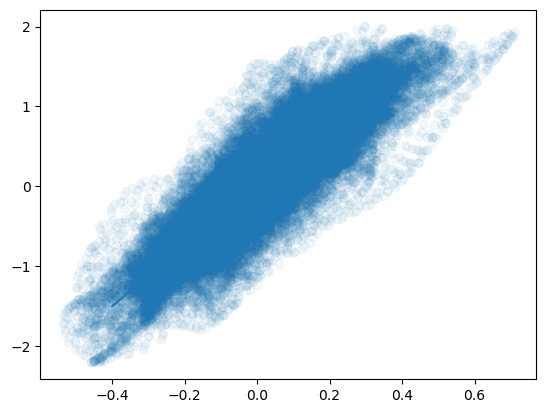

In [77]:
# Scatter plot
plt.scatter(Vx_mean_FLCT[::8, ::8], Vy_mean_filtered[::8, ::8].T, alpha = 0.05)
plt.plot([-0.4,0.4],[-1.5, 1.5])

In [78]:
from scipy.stats import pearsonr

In [80]:
r = pearsonr(Vx_mean_FLCT.flatten(), Vy_mean_filtered.T.flatten()) # This tells us that we may have looked at different parameters before
print(r)

PearsonRResult(statistic=0.8691796832794199, pvalue=0.0)


In [82]:
r = pearsonr(Vx_mean_FLCT.flatten(), Vx_mean_filtered.flatten())
print(r)

PearsonRResult(statistic=-0.03036446342526823, pvalue=0.0)


<p style="color:blue; font-family:sans-serif">
    We have come to conclusion that there was an error in loading V<sub>x</sub> and V<sub>y</sub> and that it affected previous comparisons. 
    Transposed V<sub>y</sub> from simulation matches well with FLCT V<sub>x</sub>.
</p>

In [91]:
# Next step is to compare FLCT Vy and simulation Vx.T
Vy_mean_FLCT = temporal_avg(Int_series_vy, 0, 180)
Vx_mean_sim = temporal_avg(Vx, 0, 180) # simulation
Vx_mean_sim = Vx_mean_sim/1E5
Vy_mean_sim = temporal_avg(Vy, 0, 180) # simulation
Vy_mean_sim = Vy_mean_sim/1E5

In [92]:
Vx_mean_filtered = gaussian_filter(Vx_mean_sim, 25, mode = "wrap")
Vy_mean_filtered = gaussian_filter(Vy_mean_sim, 25, mode = "wrap")

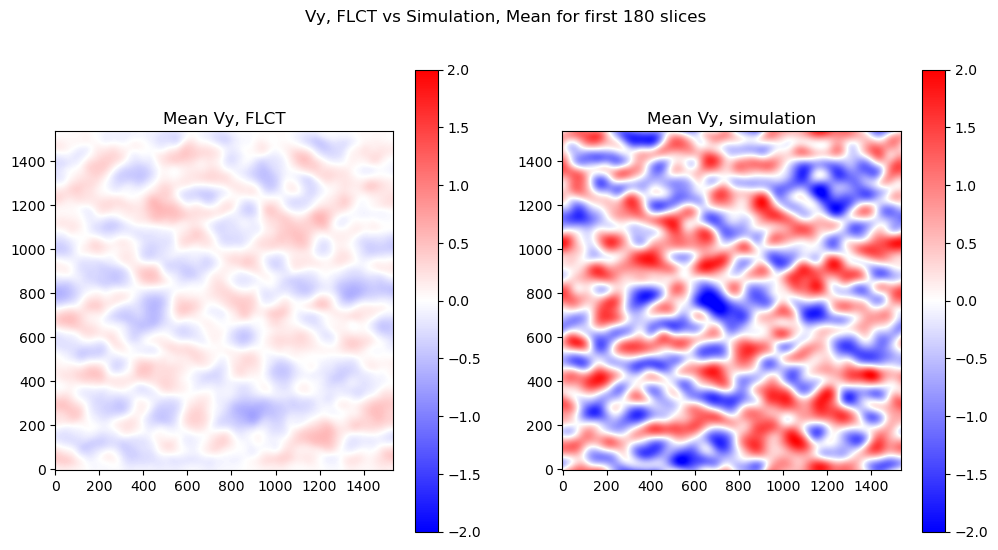

In [94]:
# Ploting mean velocties vs FLCT deriven
fig = plt.figure(figsize = (12,6))
fig.suptitle("Vy, FLCT vs Simulation, Mean for first 180 slices")
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(Vy_mean_FLCT[:, :], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Mean Vy, FLCT") 
fig.colorbar(im1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Vy_mean_filtered[:, :], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("Mean Vy, simulation") 
fig.colorbar(im2)

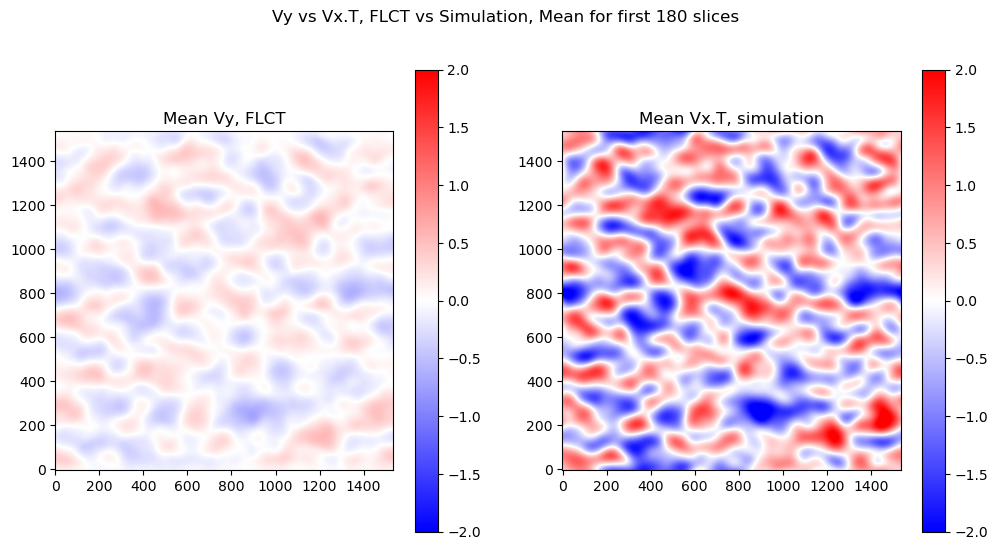

In [98]:
# Ploting mean velocties vs FLCT deriven
fig = plt.figure(figsize = (12,6))
fig.suptitle("Vy vs Vx.T, FLCT vs Simulation, Mean for first 180 slices")
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(Vy_mean_FLCT[:, :], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Mean Vy, FLCT") 
fig.colorbar(im1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Vx_mean_filtered[:, :].T, origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("Mean Vx.T, simulation") 
fig.colorbar(im2)

In [99]:
ry = pearsonr(Vy_mean_FLCT.flatten(), Vx_mean_filtered.T.flatten())
print(ry)

PearsonRResult(statistic=0.8511322525071755, pvalue=0.0)


<p>
    Practically the same thing!
</p>

<h2>Changing $\sigma$ to see the impact (code uses 45)</h2>

In [100]:
Vx_mean_filtered45 = gaussian_filter(Vx_mean_sim, 45, mode = "wrap")
Vy_mean_filtered45 = gaussian_filter(Vy_mean_sim, 45, mode = "wrap")

In [103]:
r_x = pearsonr(Vx_mean_FLCT.flatten(), Vy_mean_filtered45.T.flatten()) 
print(r_x)

PearsonRResult(statistic=0.8648380309385256, pvalue=0.0)


In [104]:
r_y = pearsonr(Vy_mean_FLCT.flatten(), Vx_mean_filtered45.T.flatten())
print(r_y)

PearsonRResult(statistic=0.8531161490038744, pvalue=0.0)


<p>
    For $\sigma$ = 25 and $\sigma$ = 45 the Pearson's coefficient is the almost same!
</p>

<h3>$\sigma$ = 30</h3>

In [105]:
Vx_mean_filtered30 = gaussian_filter(Vx_mean_sim, 30, mode = "wrap")
Vy_mean_filtered30 = gaussian_filter(Vy_mean_sim, 30, mode = "wrap")

In [106]:
r_x = pearsonr(Vx_mean_FLCT.flatten(), Vy_mean_filtered30.T.flatten()) 
print(r_x)

PearsonRResult(statistic=0.8841811639662425, pvalue=0.0)


In [107]:
r_y = pearsonr(Vy_mean_FLCT.flatten(), Vx_mean_filtered30.T.flatten())
print(r_y)

PearsonRResult(statistic=0.866245479540126, pvalue=0.0)


In [ ]:
<p>
    For $\sigma$ = 30 slightly better correlation!
</p>

<h3 style = "color:green">$\sigma$ = 35</h3>

In [108]:
Vx_mean_filtered35 = gaussian_filter(Vx_mean_sim, 35, mode = "wrap")
Vy_mean_filtered35 = gaussian_filter(Vy_mean_sim, 35, mode = "wrap")

In [109]:
r_x = pearsonr(Vx_mean_FLCT.flatten(), Vy_mean_filtered35.T.flatten()) 
print(r_x)

PearsonRResult(statistic=0.8873157838567132, pvalue=0.0)


In [110]:
r_y = pearsonr(Vy_mean_FLCT.flatten(), Vx_mean_filtered35.T.flatten())
print(r_y)

PearsonRResult(statistic=0.8705571754428986, pvalue=0.0)


<p>
    For $\sigma$ = 35 even better than for $\sigma$ = 30 correlation!
</p>

<h3 style = "color:orange">$\sigma$ = 40</h3>

In [111]:
Vx_mean_filtered40 = gaussian_filter(Vx_mean_sim, 40, mode = "wrap")
Vy_mean_filtered40 = gaussian_filter(Vy_mean_sim, 40, mode = "wrap")

In [112]:
r_x = pearsonr(Vx_mean_FLCT.flatten(), Vy_mean_filtered40.T.flatten()) 
print(r_x)

PearsonRResult(statistic=0.8801543912079228, pvalue=0.0)


In [113]:
r_y = pearsonr(Vy_mean_FLCT.flatten(), Vx_mean_filtered40.T.flatten())
print(r_y)

PearsonRResult(statistic=0.8656154413431831, pvalue=0.0)


<p>
    Seems that $\sigma$ around 35 in gaussian_filter is the best choice for $\Delta t$ = 30s and FWHM = 1200 km in pyflct.
</p>

/tmp/ipykernel_7242/4103302804.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Vx_mean_FLCT[::8, ::8], Vy_mean_filtered35[::8, ::8].T, s=25, cmap=plt.cm.coolwarm, zorder=10)


(-2.0773531019687654, 1.7191285908222198)

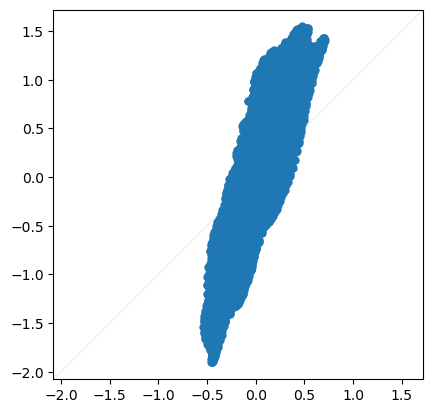

In [121]:
# Plotting scatter for sigma 35, x and y min limit set to matching values
fig, ax = plt.subplots()
ax.scatter(Vx_mean_FLCT[::8, ::8], Vy_mean_filtered35[::8, ::8].T, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.05, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

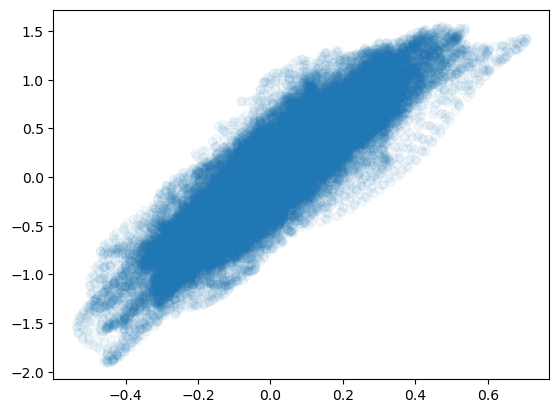

In [120]:
plt.scatter(Vx_mean_FLCT[::8, ::8], Vy_mean_filtered35[::8, ::8].T, alpha = 0.05) # when min and max aren't set as the same value

<h1 style = "color:maroon; font-family:sans-serif"><i>Further testing</i></h1>

In [ ]:
# Spatial smearing to be tested